# RSS Multivariate Normal formulation with position coordinates $[x, y]$
---

In [32]:
%whos

Variable               Type              Data/Info
--------------------------------------------------
B                      int               100
L                      int               100
Omega                  ndarray           4x4: 16 elems, type `float64`, 128 bytes
SEED                   ndarray           4: 4 elems, type `int64`, 32 bytes
Sigma                  ndarray           4x4: 16 elems, type `float64`, 128 bytes
aa                     int               3
anchor_cnt             int               4
anchor_vt              ndarray           4x2: 8 elems, type `int64`, 64 bytes
base_filename          str               _m250_d2000_j4_c4_e1.1111111111111112e-13
bb                     int               3
cov                    TensorVariable    AllocDiag.0
d                      list              n=4
d_                     ndarray           4x250: 1000 elems, type `float64`, 8000 bytes
d_real                 list              n=4
delta                  float             1.11111

In [33]:
%reset -f

In [34]:
from sympy import init_printing
init_printing()

In [35]:
import pymc3 as pm
import numpy as np
from scipy import stats
import theano.tensor as tt
from theano import shared
import matplotlib.pyplot as plt

## Building the deployment scenario
---

In [36]:
# Observed received signal strength at the anchors (this formulation assumes centralized coordination among anchors)
sample_sz = 250*10**0
# Run Monte Carlo simulation to generate the observable data considering the deployment infrastructure
L = 100 # Length
B = 100 # Breadth
bb = 3 # Path loss coefficient
aa = 3

# Anchors position
anchor_vt = np.array([[0, 0], [0, B], [L, 0], [L, B]])
anchor_cnt = len(anchor_vt)
# Target position
target_vt = np.array([[20, 80]])

## Generating measurements (Monte Carlo simulation)
---

In [37]:
def n_euclidean_distance(x, y):
    return np.sqrt(((x - y)**2).sum(axis = 1))

In [38]:
d_real = [[] for i in range(anchor_cnt)]
for i in range(0, anchor_cnt):
    d_real[i] = n_euclidean_distance(anchor_vt[i], target_vt)
d = np.repeat(d_real, sample_sz, axis = 1)

In [39]:
# the covariance of the joint distribution
sigma = np.ones(anchor_cnt)
delta = (10/(3*(10**8)))**2
Omega = delta*np.identity(anchor_cnt)
Sigma = np.diag(sigma) @ Omega @ np.diag(sigma)

# the error term 
err = np.random.multivariate_normal(mean=np.zeros(anchor_cnt), cov=Omega, size=sample_sz)

In [40]:
t_hat = d.T/(3*(10**8)) + err;

## Building the PyMC model
---

In [41]:
def t_euclidean_distance(x, y):
    return tt.sqrt(tt.sqr(x - y).sum(axis = 0))

with pm.Model() as pos_model:
    x = pm.Uniform('x', 0, L)
    y = pm.Uniform('y', 0, B)
    ϕ = tt.stack([x, y], axis = 1)


In [42]:
with pos_model:
    d = [[] for i in range(anchor_cnt)]
    μ = [[] for i in range(anchor_cnt)]
    for i in range(0, anchor_cnt):
        d[i] = pm.Deterministic('d' + str(i) , t_euclidean_distance(anchor_vt[i], ϕ))
        μ[i] = d[i]/(3*(10**8))

In [43]:
with pos_model:
    σ = [[] for i in range(anchor_cnt)]
    for i in range(anchor_cnt):
        σ[i] = pm.HalfNormal('σ__' + str(i), sd = 10)
    cov = tt.nlinalg.alloc_diag(σ)
    μ_ = tt.stack(μ).T

In [44]:
with pos_model:
    joint_obs = pm.MvNormal('joint', mu=μ_, cov=cov, observed=t_hat)

In [45]:
## pm.model_to_graphviz(pos_model)

In [46]:
n_runs, n_draws, n_jobs, n_cores, n_tunes = 1, 2000, 4, 4, 1000

In [47]:
scenario_fiename = 'rss'
metric_filename = '_trace'
sampler_fiename = '_hmc'
base_filename = '_m' + str(sample_sz) + '_d' + str(n_draws) + '_j' + str(n_jobs) + '_c' + str(n_cores) + '_e' + str(100*delta)
scenario_fiename + sampler_fiename + metric_filename + base_filename

'rss_hmc_trace_m250_d2000_j4_c4_e1.1111111111111112e-13'

In [48]:
trace_filename = './rst/' + scenario_fiename + sampler_fiename + metric_filename + base_filename
trace_filename

'./rst/rss_hmc_trace_m250_d2000_j4_c4_e1.1111111111111112e-13'

### Simple run for illustrative plots
---

In [49]:
## Set random seed per chain
SEED = np.random.randint(10**9, size = n_jobs)

## If error becomes bigger, it's needed more measurements to converge
with pos_model:
    trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
                      chains = n_jobs, cores = n_cores, tune = n_tunes, random_seed=SEED.tolist())

<ipython-input-49-1d7128780a2a>:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.


## Summarizing results
---

In [130]:
%matplotlib inline

In [131]:
plt.rcParams.update(plt.rcParamsDefault)

<ipython-input-23-04cacaa9a37a>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
/home/hhilleshein/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>],
       [<AxesSubplot:title={'center':'y'}>,
        <AxesSubplot:title={'center':'y'}>],
       [<AxesSubplot:title={'center':'d0'}>,
        <AxesSubplot:title={'center':'d0'}>],
       [<AxesSubplot:title={'center':'d1'}>,
        <AxesSubplot:title={'center':'d1'}>],
       [<AxesSubplot:title={'center':'d2'}>,
        <AxesSubplot:title={'center':'d2'}>],
       [<AxesSubplot:title={'center':'d3'}>,
        <AxesSubplot:title={'center':'d3'}>],
       [<AxesSubplot:title={'center':'σ__0'}>,
        <AxesSubplot:title={'center':'σ__0'}>],
       [<AxesSubplot:title={'center':'σ__1'}>,
        <AxesSubplot:title={'center':'σ__1'}>],
       [<AxesSubplot:title={'center':'σ__2'}>,
        <AxesSubplot:title={'center':'σ__2'}>],
       [<AxesSubplot:title={'center':'σ__3'}>,
        <AxesSubplot:title={'center':'σ__3'}>]], dtype=object)

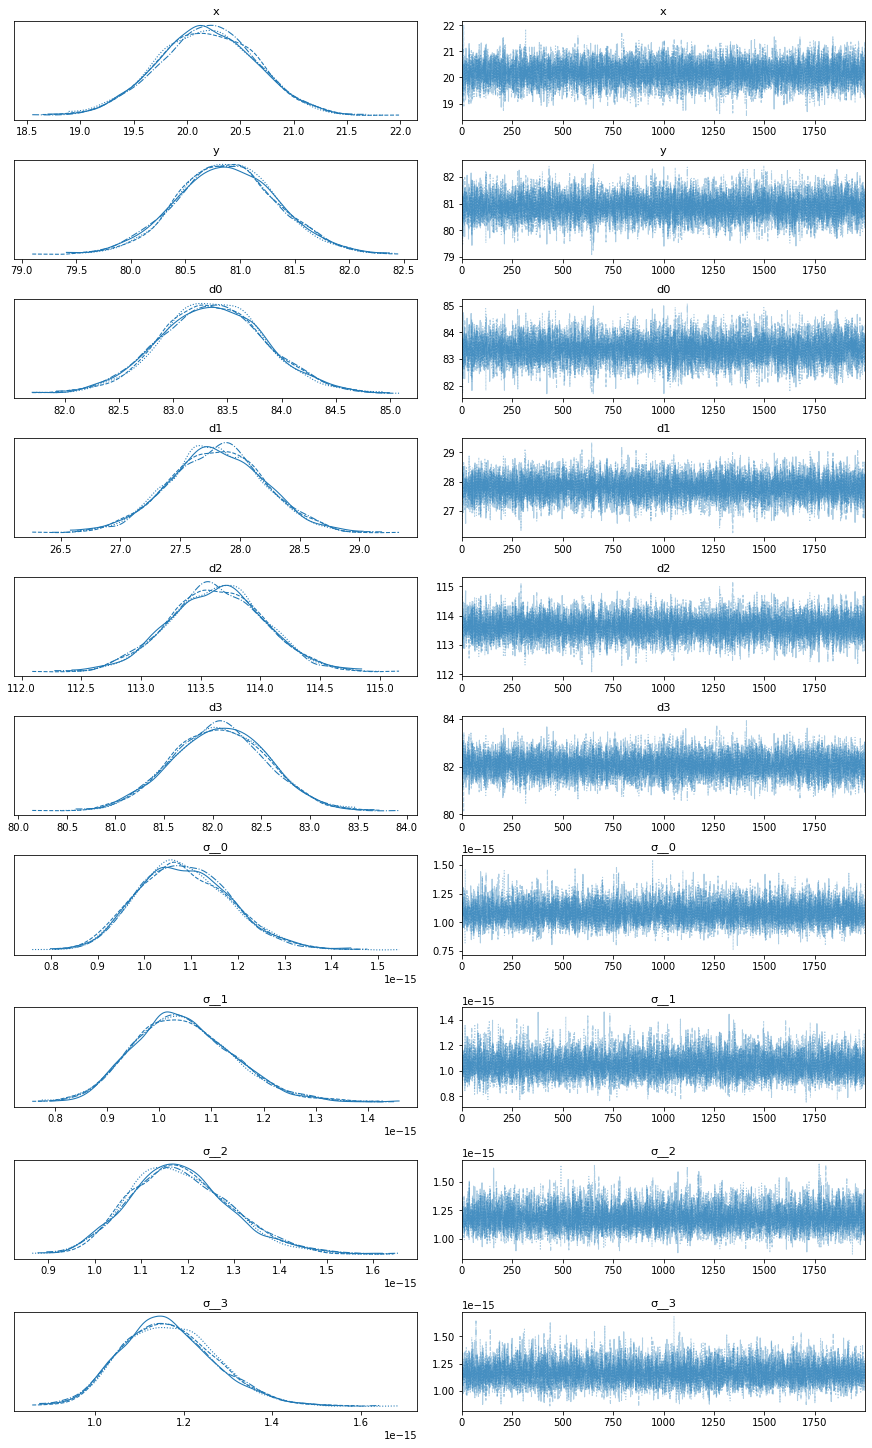

In [23]:
pm.traceplot(trace)
 

In [24]:
plt.show()

In [68]:
pm.summary(trace)

mean            sd      mc_error       hpd_2.5      hpd_97.5  \
x     2.083354e+01  1.020795e+00  1.014217e-02  1.876736e+01  2.273791e+01   
y     8.072315e+01  1.017914e+00  1.049780e-02  7.889403e+01  8.289085e+01   
d0    8.337381e+01  1.071491e+00  1.161973e-02  8.124705e+01  8.543825e+01   
d1    2.840605e+01  8.987969e-01  7.302032e-03  2.670513e+01  3.020157e+01   
d2    1.130700e+02  8.992355e-01  7.374564e-03  1.112762e+02  1.147888e+02   
d3    8.148532e+01  1.070973e+00  1.128772e-02  7.946015e+01  8.361066e+01   
σ__0  5.207719e-15  4.754993e-16  4.505330e-18  4.314069e-15  6.155206e-15   
σ__1  6.521372e-15  6.039230e-16  5.055274e-18  5.363165e-15  7.745072e-15   
σ__2  5.287606e-15  4.807180e-16  4.336481e-18  4.341322e-15  6.195524e-15   
σ__3  5.151051e-15  4.663279e-16  4.683529e-18  4.210200e-15  6.016271e-15   

             n_eff      Rhat  
x     10631.163841  1.000015  
y      9410.152858  1.000145  
d0     8689.657053  1.000233  
d1    14029.487368  0.999778  
d2    13743.693834  0.999784  
d3     9804.605809  1.000124  
σ__0  10514.541274  0.999904  
σ__1  10473.544755  1.000080  
σ__2  10897.954384  0.999870  
σ__3  10168.976436  0.999879

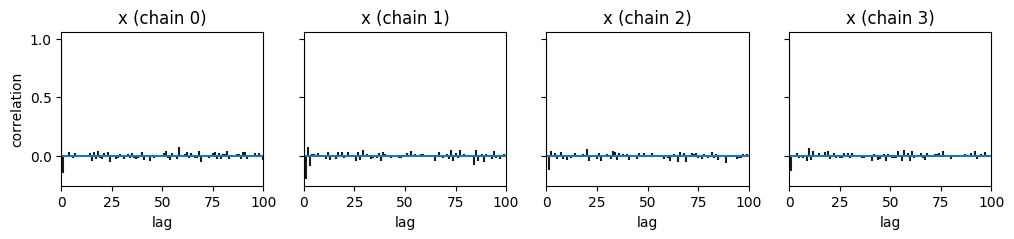

In [69]:
pm.autocorrplot(trace, varnames=['x'])
plt.show()

In [70]:
pm.effective_n(t)

NameError: name 't' is not defined

In [71]:
pm.gelman_rubin(t)

NameError: name 't' is not defined

In [72]:
pm.geweke(t['x'])[0][:]

NameError: name 't' is not defined

In [73]:
t.varnames

NameError: name 't' is not defined

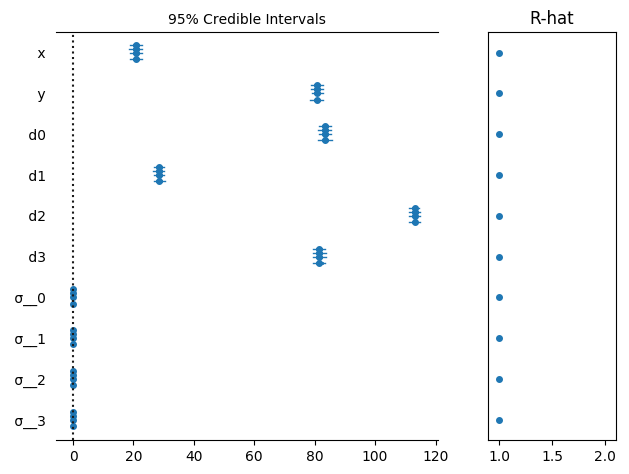

In [74]:
pm.forestplot(trace)
plt.show()

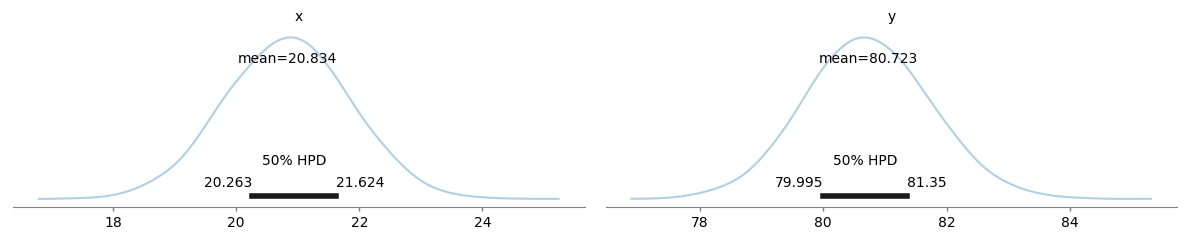

In [75]:
pm.plot_posterior(trace, varnames=['x', 'y'], kde_plot=True, alpha_level=.5)
plt.show()

## Seaborn plots
---

In [134]:
x_samples = trace['x']
y_samples = trace['y']

In [135]:
scenario_fiename = 'rss'
metric_filename = '_kde'
sampler_fiename = '_hmc'
base_filename = '_m' + str(sample_sz) + '_d' + str(n_draws) + '_j' + str(n_jobs) + '_c' + str(n_cores) + '_e' + str(100*delta)
scenario_fiename + sampler_fiename + metric_filename + base_filename

'rss_hmc_kde_m250_d2000_j4_c4_e1.1111111111111112e-13'

In [136]:
out_filename = './fig/' + scenario_fiename + sampler_fiename + metric_filename + base_filename + '.out'
out_filename

'./fig/rss_hmc_kde_m250_d2000_j4_c4_e1.1111111111111112e-13.out'

In [137]:
np.savetxt(out_filename, np.c_[x_samples, y_samples])

In [138]:
true_x, true_y = target_vt[0, 0], target_vt[0, 1]
true_x, true_y

(20, 80)

In [139]:
np.sqrt(np.mean(x_samples - true_x)**2)

In [140]:
np.sqrt(np.mean(y_samples - true_y)**2)

In [141]:
import seaborn as sns; sns.set(color_codes=True)

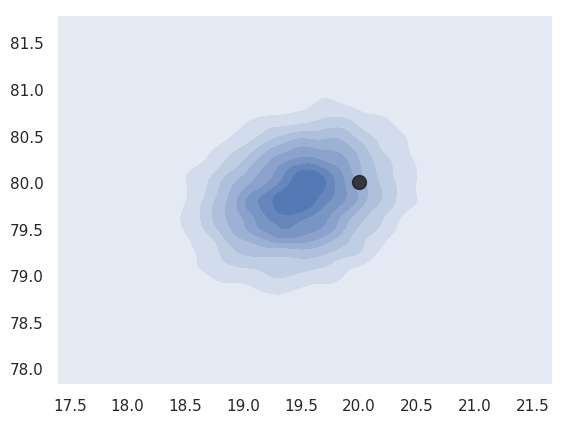

In [142]:
ax = sns.kdeplot(x_samples, y_samples, shade=True)
sns.regplot(x=np.array([true_x]), y=np.array([true_y]), scatter=True, fit_reg=False, marker='o', color = 'k',
            scatter_kws={"s": 100})
plt.show()

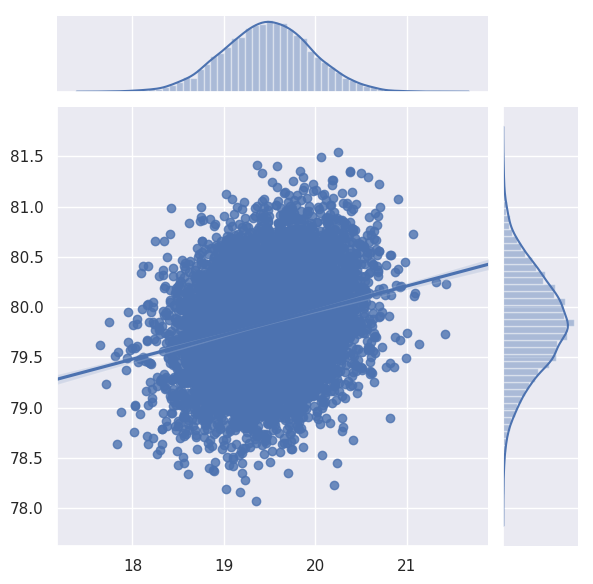

In [143]:
ax = sns.jointplot(x_samples, y_samples, color="b", kind="reg")
plt.show()

In [144]:
scenario_fiename = 'rss'
metric_filename = '_kde'
sampler_fiename = '_hmc'
base_filename = '_m' + str(sample_sz) + '_d' + str(n_draws) + '_j' + str(n_jobs) + '_c' + str(n_cores) + '_e' + str(100*delta)
scenario_fiename + sampler_fiename + metric_filename + base_filename

'rss_hmc_kde_m250_d2000_j4_c4_e1.1111111111111112e-13'

In [145]:
fig_filename = './fig/' + scenario_fiename + sampler_fiename + metric_filename + base_filename + '.pdf'
fig_filename

'./fig/rss_hmc_kde_m250_d2000_j4_c4_e1.1111111111111112e-13.pdf'

In [146]:
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex = True)

import matplotlib.pyplot as plt

plt.figure( figsize = (7.5, 7.5) )
fig = plt.gcf()

params = {'backend': 'pdf',
          'axes.labelsize': 16,
          'font.size': 16,
          'legend.fontsize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'text.usetex': True}
# plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update(params)

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

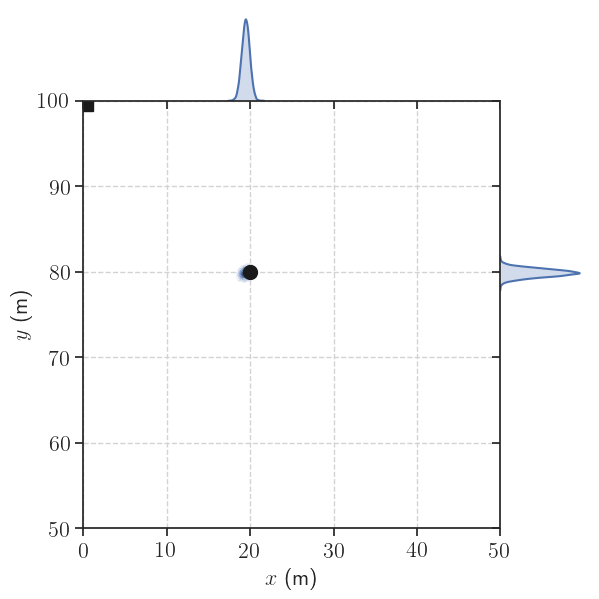

In [147]:
import matplotlib.pyplot as plt
plt.figure( figsize = (7.5, 7.5) )
sns.set_style("ticks")

ax = sns.jointplot(x_samples, y_samples, kind="kde", alpha=.5, n_levels = 15, \
                   xlim={0, 50}, ylim={50, 100}, \
                   space = 0, joint_kws=dict(shade_lowest=False)).set_axis_labels('$x$ (m)', '$y$ (m)')
ax.ax_joint.plot([target_vt[0, 0]], [target_vt[0, 1]], 'ko', markersize = 10)
ax.ax_joint.plot([0], [100], 'ks', markersize = 15)
ax.ax_joint.grid(ls='--', color='lightgray')
plt.savefig(fig_filename, bbox_inches = 'tight', pad_inches = .1)
plt.show()

In [50]:
from scipy import stats

def from_posterior(samples, param):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)
    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return pm.Interpolated(param, x, y, testval=np.mean(samples))

def from_posterior_2(samples): # For mixture prior
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)
    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return pm.Interpolated.dist(x, y, testval=np.mean(samples))

In [51]:
try:
    trace = traces[0]
except:
    pass
traces = [trace]

# The iterative method

In [52]:
percentage = np.array([0.8, 0.2]) # For mixture prior
sd_multi = 2; # For mixture and normal priors

In [53]:
import math

In [54]:
d_ = np.repeat(d_real, sample_sz, axis = 1)

for it in range(20):
  # generate more data
    # the error term 
    err = np.random.multivariate_normal(mean=(0, 0, 0, 0), cov=Omega, size=sample_sz)
    t_hat = d_.T/(3*(10**8)) + err;
    #with pos_model:
    rep_model = pm.Model()
    with rep_model:
        ## Simply use the posterior as prior
        #x = from_posterior(trace['x'],'x')
        #y = from_posterior(trace['y'],'y')
        
        ## Normal distribution with the same mean than the Posterior distribution
        #x = pm.Bound(pm.Normal, lower=0.0, upper=L)("x",mu=np.mean(trace["x"]),sd=sd_multi*math.sqrt(np.var(trace["x"])))
        #y = pm.Bound(pm.Normal, lower=0.0, upper=B)("y",mu=np.mean(trace["y"]),sd=sd_multi*math.sqrt(np.var(trace["y"])))
        
        ## Prior distribution is a mix of the posterior with a Normal
        x = pm.Mixture('x', w=percentage, comp_dists=[pm.Normal.dist(mu = np.mean(trace['x']) , sd = sd_multi*math.sqrt(np.var(trace['x']))), from_posterior_2(trace['x'])], testval=np.mean(trace['x']))
        y = pm.Mixture('y', w=percentage, comp_dists=[pm.Normal.dist(mu = np.mean(trace['y']) , sd = sd_multi*math.sqrt(np.var(trace['y']))), from_posterior_2(trace['y'])], testval=np.mean(trace['y']))
        for i in range(0, anchor_cnt):
            σ[i] = pm.HalfNormal('σ__' + str(i), sd = 10)
        ϕ = tt.stack([x, y], axis = 1)
        d = [[] for i in range(anchor_cnt)]
        μ = [[] for i in range(anchor_cnt)]
        for i in range(0, anchor_cnt):
            d[i] = pm.Deterministic('d' + str(i) , t_euclidean_distance(anchor_vt[i], ϕ))
            μ[i] = d[i]/(3*(10**8))
        μ_ = tt.stack(μ).T
       
        cov = tt.nlinalg.alloc_diag(σ)
        joint_obs = pm.MvNormal('joint', mu=μ_, cov=cov, observed=t_hat)
        trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
                      chains = n_jobs, cores = n_cores, tune = n_tunes, random_seed=SEED.tolist())  
        traces.append(trace)

<ipython-input-54-4dc029e901d0>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.
<ipython-input-54-4dc029e901d0>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
<ipython-input-54-4dc029e901d0>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.
<ipython-input-54-4dc029e901d0>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.
<ipython-input-54-4dc029e901d0>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.
<ipython-input-54-4dc029e901d0>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.
<ipython-input-54-4dc029e901d0>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.
<ipython-input-54-4dc029e901d0>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.
<ipython-input-54-4dc029e901d0>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.
<ipython-input-54-4dc029e901d0>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.
<ipython-input-54-4dc029e901d0>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.
<ipython-input-54-4dc029e901d0>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.
<ipython-input-54-4dc029e901d0>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.
<ipython-input-54-4dc029e901d0>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 33 seconds.
<ipython-input-54-4dc029e901d0>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.
<ipython-input-54-4dc029e901d0>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.
<ipython-input-54-4dc029e901d0>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.
<ipython-input-54-4dc029e901d0>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.
<ipython-input-54-4dc029e901d0>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.
<ipython-input-54-4dc029e901d0>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = n_draws, step = pm.NUTS(target_accept = .8), \
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ__3, σ__2, σ__1, σ__0, y, x]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.


In [99]:
pm.traceplot(trace)

RuntimeError: latex was not able to process the following string:
b'\\u03c3__0'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode

(/koti/hhillesh19/.cache/matplotlib/tex.cache/687398aa5b091915a288f056801ff004.
tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./687398aa5b091915a288f056801ff004.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! Package inputenc Error: Unicode char \u8:σ not set up for use with LaTeX.

See the inputenc package documentation for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.14 \fontsize{12.000000}{15.000000}{\sffamily σ
                                                 __0}
No pages of output.
Transcript written on 687398aa5b091915a288f056801ff004.log.




In [100]:
plt.show()

RuntimeError: latex was not able to process the following string:
b'\\u03c3__0'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode

(/koti/hhillesh19/.cache/matplotlib/tex.cache/687398aa5b091915a288f056801ff004.
tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./687398aa5b091915a288f056801ff004.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! Package inputenc Error: Unicode char \u8:σ not set up for use with LaTeX.

See the inputenc package documentation for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.14 \fontsize{12.000000}{15.000000}{\sffamily σ
                                                 __0}
No pages of output.
Transcript written on 687398aa5b091915a288f056801ff004.log.




<Figure size 1200x2000 with 20 Axes>

RuntimeError: latex was not able to process the following string:
b'\\u03c3__0'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode

(/koti/hhillesh19/.cache/matplotlib/tex.cache/687398aa5b091915a288f056801ff004.
tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./687398aa5b091915a288f056801ff004.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! Package inputenc Error: Unicode char \u8:σ not set up for use with LaTeX.

See the inputenc package documentation for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.14 \fontsize{12.000000}{15.000000}{\sffamily σ
                                                 __0}
No pages of output.
Transcript written on 687398aa5b091915a288f056801ff004.log.




<Figure size 1200x2000 with 20 Axes>

Posterior distributions after 21 iterations.


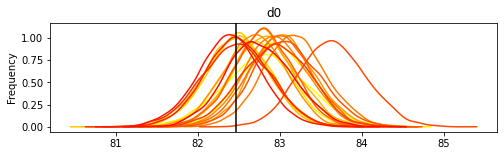

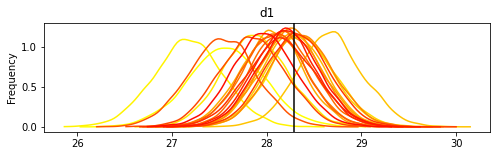

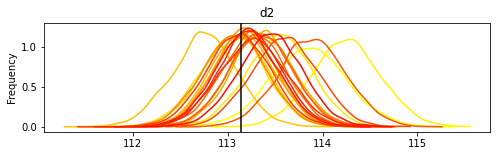

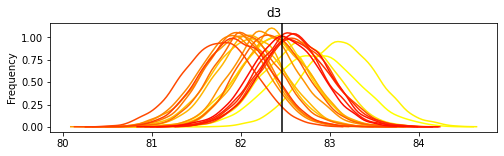

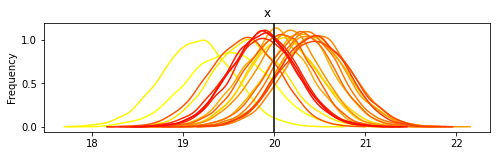

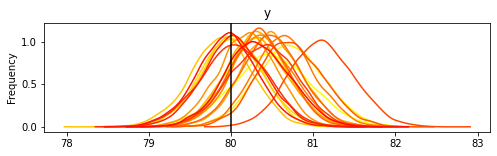

In [55]:
import matplotlib as mpl

print('Posterior distributions after ' + str(len(traces)) + ' iterations.')
traced_itens = []
for i in range(0, anchor_cnt):
    traced_itens.append("d" + str(i))
traced_itens.append('x')
traced_itens.append('y')
cmap = mpl.cm.autumn
for param in traced_itens:
    plt.figure(figsize=(8, 2))
    for update_i, trace in enumerate(traces):
        samples = trace[param] 
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples[:])(x)
        plt.plot(x, y, color=cmap(1 - update_i / len(traces)))
    plt.axvline({'α': aa, 'β': bb, 'd0': d_real[0], 'd1': d_real[1]
                 , 'd2': d_real[2], 'd3': d_real[3]
                 , 'x': target_vt[0][0], 'y': target_vt[0][1]}[param], c='k')
    plt.ylabel('Frequency')
    plt.title(param)
    plt.show()